In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io
import random
from gensim.models import Word2Vec
from datetime import datetime


In [2]:
# function to work around loading a GPU generated pickle on local CPU machine
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:
# load synthesizer from saved object
with open('../models/TVAE_synthesizer.pkl', 'rb') as input:
    synthesizer = CPU_Unpickler(input).load()

# modify device from cuda:0 to cpu
synthesizer.device = 'cpu'

In [4]:
# check out sample
N = 100000
sample = synthesizer.sample(N)
np.set_printoptions(suppress = True, precision = 2)

In [5]:
df_input = pd.read_csv('../data/cc_data_input.csv')

In [6]:
input_columns = list(df_input.columns)[1:]

In [7]:
df_sample = pd.DataFrame(sample, columns=input_columns) 
pd.set_option('display.max_columns', 45)
df_sample.head()

,Purchase Amount,Account Type_bank_account,Account Type_credit_card,Consumer Gender_female,Consumer Gender_male,SIC Description_Book Stores,"SIC Description_Communications Services, Not Elsewhere Classified",SIC Description_Drug Stores and Proprietary Stores,SIC Description_Eating Places,SIC Description_Family Clothing Stores,SIC Description_Gasoline Service Stations,SIC Description_Grocery Stores,SIC Description_Miscellaneous Food Stores,SIC Description_Other,SIC Description_Taxicabs,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,period_of_month_end,period_of_month_mid,period_of_month_start,"Age Range_(20, 25]","Age Range_(25, 30]","Age Range_(30, 35]","Age Range_(35, 40]","Age Range_(40, 45]","Age Range_(45, 50]","Age Range_(50, 55]","Age Range_(55, 60]","Age Range_(60, 65]","Age Range_(65, 70]",retailerVec_01,retailerVec_02,retailerVec_03,retailerVec_04,retailerVec_05,retailerVec_06,retailerVec_07,retailerVec_08,retailerVec_09,retailerVec_10
0,43.637126,-0.000216,0.999873,0.999992,-0.000030,0.000022,0.000038,-0.000070,0.000022,-0.000060,-0.000104,0.999749,0.000002,0.000124,-1.769241e-05,-0.000051,0.000050,1.680832e-05,0.000011,-0.000052,-0.000046,-0.000030,0.000060,0.000090,0.000009,0.000112,-0.000046,0.000069,-0.000096,-0.000011,0.000077,0.000079,0.000044,-0.000012,-0.000056,1.251605,-2.236769,-0.495871,-0.153252,0.371609,-2.277832,-0.626206,-1.874493,-0.068517,-1.118880
1,19.177288,0.999838,-0.000053,0.999833,0.000102,0.000017,0.000022,0.000006,0.000029,0.000020,0.000026,0.000022,-0.000048,0.000079,-7.833307e-07,-0.000009,-0.000032,-9.903645e-05,0.000049,-0.000012,0.000033,-0.000049,-0.000058,-0.000113,0.000014,-0.000064,-0.000016,0.000083,-0.000035,0.000025,-0.000017,-0.000062,0.000078,0.000021,0.000009,1.329056,-2.048518,0.147038,0.295618,-0.627274,-0.539141,-0.988249,-1.823195,-3.138976,0.184412
2,52.931847,1.000018,0.000266,0.999904,0.000096,-0.000037,0.000024,-0.000040,-0.000058,-0.000041,-0.000021,1.000073,0.000022,0.000041,3.401805e-05,0.000078,0.000038,3.141115e-05,-0.000033,0.000134,-0.000012,0.000002,-0.000074,-0.000100,-0.000088,0.000091,0.000073,0.000035,0.000082,-0.000051,0.000109,-0.000085,0.000037,0.000010,-0.000004,-0.169650,-0.492758,-0.571143,-1.499488,0.078439,-2.837638,-0.675363,-1.256362,0.149296,-1.154424
3,26.781112,0.999781,0.000264,0.999945,0.000050,0.000048,0.000043,0.000016,0.000070,-0.000014,0.000023,-0.000009,0.000009,0.000026,4.771056e-05,-0.000012,-0.000028,-1.793996e-05,0.000090,-0.000038,0.000108,0.000060,-0.000064,0.000026,0.000005,0.000002,0.000125,0.000109,0.000037,0.000081,0.000089,-0.000043,-0.000096,-0.000034,0.000031,1.362294,-1.019319,-0.640079,-0.542601,-1.445700,-1.948847,-0.573202,-1.824561,-2.189133,-1.295971
4,42.194918,0.999913,0.000075,-0.000053,1.000234,0.000101,-0.000012,-0.000009,-0.000016,0.000024,1.000442,-0.000137,0.000100,0.000055,5.748469e-05,-0.000003,0.000010,1.332274e-07,-0.000099,0.000046,-0.000029,-0.000031,0.000081,-0.000031,-0.000032,0.000052,-0.000075,-0.000022,0.000018,-0.000028,0.000028,-0.000010,0.000004,-0.000049,0.000065,1.574258,-0.451034,-2.028430,2.018953,-2.068643,-1.940791,-0.477880,-2.264411,-2.220442,-0.340201


In [8]:
# return series of dummy variables with given column name
def reverse_dummy(df, col_name):
    # get index of columns that starts with col_name, for example, Gender_male, Gender_female for col_name = `Gender`
    idx = [i for i, s in enumerate(list(df.columns)) if col_name in s]
    tmp = df.iloc[:,idx]
    # find column name for absolute max in each row and put into one series
    df_output = pd.Series(tmp.abs().idxmax(axis=1), name = col_name)
    
    # remove strings with col_name plus underscore
    df_output = df_output.map(lambda x: x.replace(col_name + '_',''))
    return df_output

In [9]:
#df_purchase = df_sample.iloc[:,[0,1]]
df_purchase = df_sample.iloc[:,[0]]
df_age = reverse_dummy(df_sample,'Age Range')
df_account = reverse_dummy(df_sample,'Account Type')
df_gender = reverse_dummy(df_sample,'Consumer Gender')
df_SIC = reverse_dummy(df_sample,'SIC Description')
df_dw = reverse_dummy(df_sample,'day_of_week')
df_pm = reverse_dummy(df_sample,'period_of_month')

In [10]:
#df_reverse = pd.concat([df_purchase,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)
df_reverse = pd.concat([df_purchase,df_age,df_account,df_gender,df_SIC,df_dw,df_pm], axis=1)

#pd.set_option('display.max_rows', N)
print(df_reverse.shape)
df_reverse.head()

(100000, 7)


,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month
0,43.637126,"(20, 25]",credit_card,female,Grocery Stores,Thursday,mid
1,19.177288,"(30, 35]",bank_account,female,Other,Saturday,mid
2,52.931847,"(45, 50]",bank_account,female,Grocery Stores,Thursday,mid
3,26.781112,"(25, 30]",bank_account,female,Eating Places,Tuesday,end
4,42.194918,"(25, 30]",bank_account,male,Gasoline Service Stations,Sunday,end


In [11]:
def return_age(age_range):
    age_range = age_range.replace('(','').replace(']','').replace(' ','')
    r1 = int(age_range.split(',')[0])
    r2 = int(age_range.split(',')[1])
    return random.choice(list(range(r1+1, r2+1)))

In [12]:
df_reverse['Age'] = df_reverse.apply(lambda x: return_age(x['Age Range']), axis = 1)
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age
0,43.637126,"(20, 25]",credit_card,female,Grocery Stores,Thursday,mid,22
1,19.177288,"(30, 35]",bank_account,female,Other,Saturday,mid,31
2,52.931847,"(45, 50]",bank_account,female,Grocery Stores,Thursday,mid,46
3,26.781112,"(25, 30]",bank_account,female,Eating Places,Tuesday,end,29
4,42.194918,"(25, 30]",bank_account,male,Gasoline Service Stations,Sunday,end,29


In [13]:
#df_reverse['SIC Description'].value_counts()[:9].index.tolist()

In [14]:
##retailer_map_grouped
#for i in range(0,100):
#    word_list = retailer_map_grouped[df_SIC_vector['SIC Description'][i]]
#    print(df_SIC_vector['SIC Description'][i])
#    min_idx = model.wv.distances(df_SIC_vector['retailerVec'][i], other_words = word_list).argmin()
#    print(word_list[min_idx])
#    print('\n')

In [16]:
# load the retailer_map
with open('../models/retailer_map_grouped.pkl', 'rb') as input:
    retailer_map_grouped = pickle.load(input)  

In [18]:
# reverse retailerVec back to retailers
idx = [i for i, s in enumerate(list(df_sample.columns)) if 'retailerVec' in s]
df_retailerVec = df_sample.iloc[:,idx]  

# put retailer vectors into one column
df_retailerVec['retailerVec'] = df_retailerVec.values.tolist()
df_SIC_vector = pd.concat([df_reverse['SIC Description'], df_retailerVec['retailerVec']],axis = 1)
df_SIC_vector.head()

d:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SIC Description,retailerVec
0,Grocery Stores,"[1.2516047620351558, -2.236768581577983, -0.49..."
1,Other,"[1.329055953898823, -2.0485175639540367, 0.147..."
2,Grocery Stores,"[-0.16964951058493566, -0.4927580027182031, -0..."
3,Eating Places,"[1.3622935302266557, -1.0193188504518966, -0.6..."
4,Gasoline Service Stations,"[1.5742575050738994, -0.4510338161471869, -2.0..."


In [19]:
retailer_map_grouped.keys()
#retailer_map_grouped['Gasoline Service Stations']
#df_SIC_vector['SIC Description'].value_counts()

dict_keys(['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Miscellaneous Food Stores', 'Family Clothing Stores', 'Taxicabs', 'Communications Services, Not Elsewhere Classified', 'Other'])

In [20]:
# find out retailer in the same SIC and also with the most similar vector
def return_retailer_SIC(model, retailer_map_grouped, sector, vector):
    if pd.isnull(sector):
        return None
    else:
        word_list = retailer_map_grouped[sector]
        min_idx = model.wv.distances(vector, other_words = word_list).argmin()
        return word_list[min_idx]

In [23]:
model = Word2Vec.load('../models/retailer_embedding.model')
df_reverse['Normalized Retailer'] = df_SIC_vector.apply(lambda x: return_retailer_SIC(model, retailer_map_grouped, x['SIC Description'],x['retailerVec']), axis = 1)
df_reverse.head(10)

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer
0,43.637126,"(20, 25]",credit_card,female,Grocery Stores,Thursday,mid,22,Harry's
1,19.177288,"(30, 35]",bank_account,female,Other,Saturday,mid,31,Selfridges
2,52.931847,"(45, 50]",bank_account,female,Grocery Stores,Thursday,mid,46,Metro
3,26.781112,"(25, 30]",bank_account,female,Eating Places,Tuesday,end,29,Ezra's Pound
4,42.194918,"(25, 30]",bank_account,male,Gasoline Service Stations,Sunday,end,29,Petro-Canada
5,7.417835,"(25, 30]",bank_account,male,Grocery Stores,Sunday,mid,27,Fresh
6,8.965507,"(35, 40]",credit_card,male,Drug Stores and Proprietary Stores,Friday,mid,36,Shoppers Drug Mart
7,17.846653,"(35, 40]",bank_account,male,Gasoline Service Stations,Thursday,end,36,Petro-Canada
8,12.635830,"(30, 35]",credit_card,male,Grocery Stores,Monday,mid,35,T &amp; T Supermarket Inc.
9,6.947565,"(35, 40]",bank_account,male,Grocery Stores,Thursday,end,36,Bulk Barrel Inc


In [24]:
# given period_of_month (start, mid or end) and year (1989) and month (6), return index of the possible days
def return_day_index(period_of_month, year, month):
    if period_of_month == 'start':
        return list(range(1,11))
    elif period_of_month == 'mid':
        return list(range(11,21))
    else:
        return list(range(21, pd.Period(str(year) + '-' + str(month)).days_in_month + 1))
    
# function to convert day_of_week and period_of_month back to Date, given a year and a month
# Example:
# input: day_of_week = 'Monday'; period_of_month = 'start'; Y = 2020; M = 2
# output: 2020-02-03 00:00:00

def return_date(day_of_week, period_of_month, Y, M):
    # return list of days
    D = return_day_index(period_of_month, Y, M)

    tmp = pd.DataFrame({'year': [str(Y) for i in range(len(D))],
                        'month': [str(M) for i in range(len(D))],
                        'day': D})
    
    # create table with each row of year, month and day in given period
    date_period = pd.to_datetime(tmp[['year', 'month', 'day']])

    # locate index of which date is the given day_of_week
    idx_list = [i for i, s in enumerate(date_period.dt.strftime('%A')) if day_of_week in s]

    # randomly pick up one index, since it's possible one period has multiple given weekday (say Monday)
    idx = random.choice(idx_list)

    return date_period[idx]

In [25]:
Y = 2022; M = 2
df_reverse['Transaction Date'] = df_reverse.apply(lambda x: return_date(x.day_of_week, x.period_of_month, Y, M), axis = 1)
#df_reverse.drop(['day_of_week','period_of_month'], axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Age Range,Account Type,Consumer Gender,SIC Description,day_of_week,period_of_month,Age,Normalized Retailer,Transaction Date
0,43.637126,"(20, 25]",credit_card,female,Grocery Stores,Thursday,mid,22,Harry's,2022-02-17
1,19.177288,"(30, 35]",bank_account,female,Other,Saturday,mid,31,Selfridges,2022-02-12
2,52.931847,"(45, 50]",bank_account,female,Grocery Stores,Thursday,mid,46,Metro,2022-02-17
3,26.781112,"(25, 30]",bank_account,female,Eating Places,Tuesday,end,29,Ezra's Pound,2022-02-22
4,42.194918,"(25, 30]",bank_account,male,Gasoline Service Stations,Sunday,end,29,Petro-Canada,2022-02-27


In [26]:
print(df_reverse['day_of_week'].value_counts())
print(df_reverse['period_of_month'].value_counts())

Friday       15817
Saturday     15605
Thursday     14594
Monday       14044
Tuesday      13548
Wednesday    13458
Sunday       12934
Name: day_of_week, dtype: int64
end      37062
mid      31958
start    30980
Name: period_of_month, dtype: int64


In [27]:
# remove negative purchase amount
df_reverse = df_reverse[(df_reverse['Purchase Amount'] > 0)]
df_reverse.reset_index(drop=True, inplace=True)

# load processed input data to check mean purchase amount for each retailer
df_processed = pd.read_csv('../data/cc_data_processed.csv')
df_processed.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [28]:
#df_processed_G = df_processed.groupby('Normalized Retailer').agg({'Purchase Amount': {'size', 'mean'}})
#df_processed_G.sort_values([('Purchase Amount','size')], ascending=False)

In [29]:
# create columns that are mean_byRetailer_input, mean_byRetailer_syn, and apply their ratio to adjust Purchase Amount
df_reverse['mean_byRetailer_syn'] = df_reverse['Normalized Retailer'].map(df_reverse.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['mean_byRetailer_input'] = df_reverse['Normalized Retailer'].map(df_processed.groupby(['Normalized Retailer'])['Purchase Amount'].mean())
df_reverse['Purchase Amount Corrected'] = df_reverse.apply(lambda x: x['Purchase Amount'] * x.mean_byRetailer_input / x.mean_byRetailer_syn, axis = 1)

In [30]:
# drop intermediate values
col2drop = ['Age Range','day_of_week','period_of_month','mean_byRetailer_syn','mean_byRetailer_input']
df_reverse.drop(col2drop, axis = 1, inplace = True, errors = 'ignore')
df_reverse.head()

,Purchase Amount,Account Type,Consumer Gender,SIC Description,Age,Normalized Retailer,Transaction Date,Purchase Amount Corrected
0,43.637126,credit_card,female,Grocery Stores,22,Harry's,2022-02-17,54.358577
1,19.177288,bank_account,female,Other,31,Selfridges,2022-02-12,404.359665
2,52.931847,bank_account,female,Grocery Stores,46,Metro,2022-02-17,106.222635
3,26.781112,bank_account,female,Eating Places,29,Ezra's Pound,2022-02-22,8.650654
4,42.194918,bank_account,male,Gasoline Service Stations,29,Petro-Canada,2022-02-27,41.919132


In [31]:
# save synthesized data into csv file
#output_filename = str(Y) + '_' + datetime.strptime(str(M), "%m").strftime("%b") + '.csv'
#df_reverse.to_csv('output/' + output_filename)

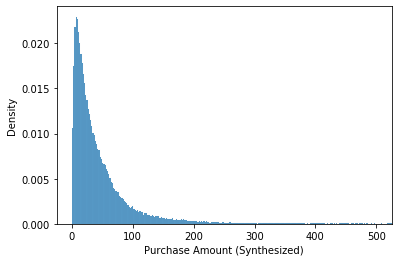

In [39]:
#sns.histplot(df_reverse['Purchase Amount'], stat="probability");
ax = sns.histplot(df_reverse['Purchase Amount Corrected'], stat="density");
plt.xlim(-25, 525);
ax.set(xlabel='Purchase Amount (Synthesized)');
#plt.savefig('figs/eda/purchase_hist_syn_ageCat70_corr.png',bbox_inches='tight')

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


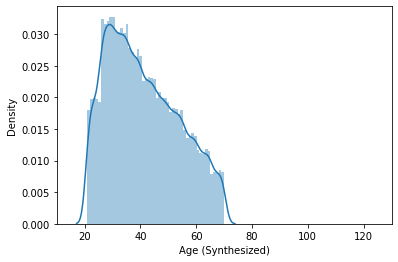

In [40]:
ax = sns.distplot(df_reverse['Age']);
plt.xlim(10, 130);
ax.set(xlabel='Age (Synthesized)');
#plt.savefig('figs/eda/age_hist_syn_ageCat70.png',bbox_inches='tight')

In [34]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [35]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df_reverse,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type  Counts    Per (%)
0  bank_account   53746  55.376848
1   credit_card   43309  44.623152


Consumer Gender
  Consumer Gender  Counts    Per (%)
0          female   53138  54.750399
1            male   43917  45.249601


Normalized Retailer
        Normalized Retailer  Counts   Per (%)
1348            Tim Hortons    5970  6.151151
1436                Walmart    3874  3.991551
981            Petro-Canada    3035  3.127093
24                   Amazon    1634  1.683581
1167                  Shell    1551  1.598063
...                     ...     ...       ...
1281  TANGLE CREEK GOLF AND       1  0.001030
497            Gravity Pope       1  0.001030
1291         Tao Restaurant       1  0.001030
478              Go For Tea       1  0.001030
749      Loonie Plus Stores       1  0.001030

[1498 rows x 3 columns]


SIC Description
                                     SIC Description  Counts    Per (%)
3                                      Eating Places   29694  30

barplot for SIC Description


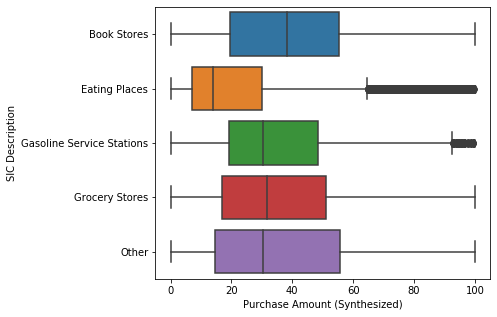

barplot for Normalized Retailer


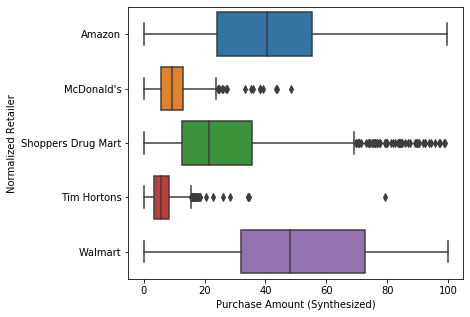

In [45]:
check_list = ['SIC Description','Normalized Retailer']
SIC_list = ['Eating Places','Gasoline Service Stations','Other','Grocery Stores','Book Stores']
retailer_list = ['Amazon','Tim Hortons',"McDonald's","Shoppers Drug Mart","Walmart"]

fig_dims = [6, 5] 
#N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    if cat == 'SIC Description':
        list_tmp = SIC_list
    else:
        list_tmp = retailer_list
    df_tmp = df_reverse[df_reverse[cat].isin(list_tmp) & (df_reverse['Purchase Amount Corrected'] < threshold)].sort_values(by = cat)
   
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount Corrected'])
    ax.set(xlabel='Purchase Amount (Synthesized)')
    #plt.savefig('figs/eda/purchase_' + cat + '_synthesized.png',bbox_inches='tight')
    plt.show()